fonte: https://colab.research.google.com/drive/1U2cbuk9JHyuctTKAHQ1fJqRliCayhDBp#scrollTo=HE-ksan_qszW

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from keras.applications.vgg16 import VGG16

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [3]:
module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [4]:
import tensorflow_datasets as tfds

In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [6]:
metadata.features["label"]
tf.compat.v1.data.get_output_shapes(raw_train)[1]

TensorShape([None])

In [7]:
IMAG_SIZE = 72 # All images will be resized to 224x224
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [8]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)

In [9]:
do_fine_tuning = True #@param {type:"boolean"}

In [10]:
print("Building model with", MODULE_HANDLE)
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(IMAG_SIZE, IMAG_SIZE,3))
for layer in conv_base.layers:
    layer.trainable = False
model = tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dropout (Dropout)           (None, 1072)              0         
                                                                 
 dense_2 (Dense)             (None, 102)               109446    
                                      

In [11]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()

In [13]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE 
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 30
hist = model.fit(
    x=train,
    epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    verbose=1).history

Epoch 1/30
63/63 [==============================] - 102s 281ms/step - loss: 4.3621 - accuracy: 0.1035 - val_loss: 4.1408 - val_accuracy: 0.0781
Epoch 2/30
63/63 [==============================] - 33s 521ms/step - loss: 3.3305 - accuracy: 0.2549 - val_loss: 3.5888 - val_accuracy: 0.1865
Epoch 3/30
63/63 [==============================] - 18s 289ms/step - loss: 2.6428 - accuracy: 0.3662 - val_loss: 3.4386 - val_accuracy: 0.1982
Epoch 4/30
63/63 [==============================] - 20s 321ms/step - loss: 1.8698 - accuracy: 0.5195 - val_loss: 3.0121 - val_accuracy: 0.2832
Epoch 5/30
63/63 [==============================] - 24s 385ms/step - loss: 1.3258 - accuracy: 0.6475 - val_loss: 3.1128 - val_accuracy: 0.2812
Epoch 6/30
63/63 [==============================] - 22s 347ms/step - loss: 0.9594 - accuracy: 0.7520 - val_loss: 2.9149 - val_accuracy: 0.2939
Epoch 7/30
63/63 [==============================] - 22s 350ms/step - loss: 0.8520 - accuracy: 0.7852 - val_loss: 2.7697 - val_accuracy: 0.355

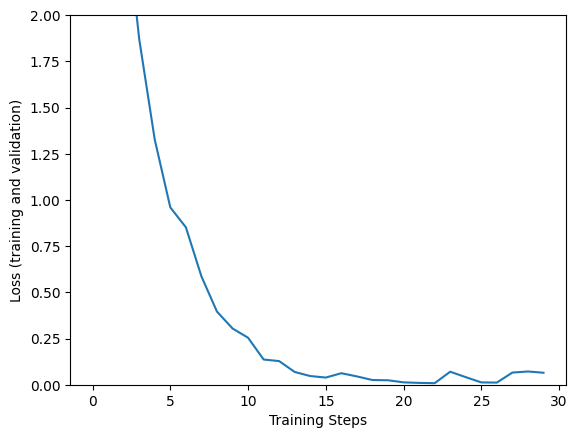

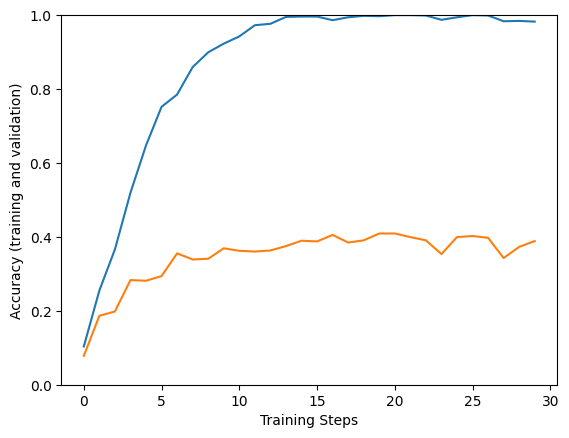

In [14]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [15]:
class_names = np.array(metadata.features['label'].names)
print(class_names)

['pink primrose' 'hard-leaved pocket orchid' 'canterbury bells'
 'sweet pea' 'english marigold' 'tiger lily' 'moon orchid'
 'bird of paradise' 'monkshood' 'globe thistle' 'snapdragon' "colt's foot"
 'king protea' 'spear thistle' 'yellow iris' 'globe-flower'
 'purple coneflower' 'peruvian lily' 'balloon flower'
 'giant white arum lily' 'fire lily' 'pincushion flower' 'fritillary'
 'red ginger' 'grape hyacinth' 'corn poppy' 'prince of wales feathers'
 'stemless gentian' 'artichoke' 'sweet william' 'carnation' 'garden phlox'
 'love in the mist' 'mexican aster' 'alpine sea holly'
 'ruby-lipped cattleya' 'cape flower' 'great masterwort' 'siam tulip'
 'lenten rose' 'barbeton daisy' 'daffodil' 'sword lily' 'poinsettia'
 'bolero deep blue' 'wallflower' 'marigold' 'buttercup' 'oxeye daisy'
 'common dandelion' 'petunia' 'wild pansy' 'primula' 'sunflower'
 'pelargonium' 'bishop of llandaff' 'gaura' 'geranium' 'orange dahlia'
 'pink-yellow dahlia?' 'cautleya spicata' 'japanese anemone'
 'black-eye

In [16]:
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"]
output_class_names = np.array(CLASS_NAMES)

In [30]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

193/193 [==============================] - 4s 22ms/step
['king protea' 'cape flower' 'petunia' ... 'osteospermum' 'spring crocus'
 'bird of paradise']


In [31]:
predicted_output_class_names = output_class_names[predicted_ids]
print(predicted_output_class_names)

['king protea' 'cape flower' 'petunia' ... 'osteospermum' 'spring crocus'
 'bird of paradise']


Precisão: 0.34509676370141484


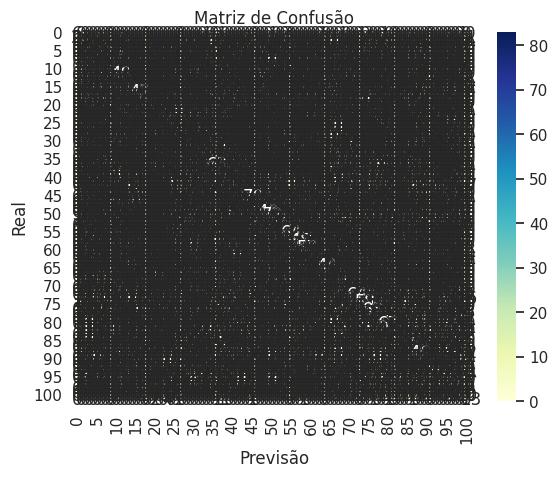

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids#np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Obter os nomes das classes
# class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

# Criar uma matriz de confusão
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão usando seaborn
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',)
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()
